## Resnet50 Features, Logistic Regressor and Performance Metrics, LOOCV- Leave One Out Cross-Validation

In [ ]:
#Path="/home/uqomulay/90days/Hist2gene/"
#Path="/home/uqomulay/90days/"
import pandas as pd
import numpy as np
import joblib
from scipy.stats import pearsonr
from numpy import array
from numpy import argmax
from numpy import load
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier;
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split; from sklearn.neural_network import MLPClassifier; from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


def ResNet50_features(unzipped_file, pre_model):
    files = pd.DataFrame(unzipped_file.namelist()).iloc[1:,:][0]
    x_scratch_train = []
    for imagePath in files:
        image = plt.imread(unzipped_file.open(imagePath)).astype('float32')
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        x_scratch_train.append(image)
    x_train = np.vstack(x_scratch_train)
    resnet_features = pd.DataFrame(pre_model.predict(x_train, batch_size=1))
    resnet_features.index = files.str.split('/', expand=True)[1].str[:-5]
    resnet_features = resnet_features.sort_index()
    return resnet_features


def Classifier_comparison_ST_Net(anndata,data,resnet_features):
    
    #resnet_features = pd.read_csv(Path+'Resnet50_features_legacy_hist2gene.csv',index_col=0)
    #pd.read_csv(Path+'hist2gene_15ge.csv',index_col=0)
    gene_exp = anndata.to_df() 
    gene_exp = gene_exp.reindex(resnet_features.index)
    gene_exp['dataset'] = gene_exp.index.str[-2:]
    resnet_features['dataset'] = gene_exp['dataset']
    
    X_train = resnet_features.loc[(resnet_features['dataset']!=data)]
    Y_train = gene_exp.loc[(gene_exp['dataset']!=data)]
    train_dataset = Y_train['dataset']
    X_test = resnet_features.loc[(resnet_features['dataset']==data)]
    Y_test = gene_exp.loc[(gene_exp['dataset']==data)]

    model_c = LogisticRegression(max_iter=10000,penalty='elasticnet',C=0.1,solver='saga',l1_ratio=0.5)

    Y = pd.DataFrame(index=Y_train.index,columns=Y_train.columns)
    
    for i in gene_exp.iloc[:,:-1].columns:
        Y[i] = Y_train.groupby('dataset')[i].apply(lambda x: (x-np.mean(x))/(np.std(x)))
    Y = Y.iloc[:,:-1]
    Y = Y.apply(lambda x: [0 if y <= 0 else 1 for y in x])
    Y = Y.astype('int64')
    Y['dataset'] = train_dataset

    Y_test = Y_test.iloc[:,:-1]
    Y_test = preprocessing.StandardScaler().fit_transform(Y_test)
    Y_test = pd.DataFrame(data=Y_test)
    Y_test = Y_test.apply(lambda x: [0 if y <= 0 else 1 for y in x])
    Y_test = Y_test.astype('int64')



    clf_resnet = MultiOutputClassifier(model_c).fit(X_train.iloc[:,:-1], Y.iloc[:,:-1])
    joblib.dump(clf_resnet, Path+data+'_class.pkl')
    clf_resnet = joblib.load(Path+data+'_class.pkl')
    pred = clf_resnet.predict(X_test.iloc[:,:-1])

    score_auc = []; score_F1 = []; score_precision = []; score_recall = []
    for i in range(len(pred[0])):
        score = roc_auc_score(pred[:,i], Y_test.iloc[:,i])
        score_auc.append(score)

    for i in range(len(pred[0])):
        score = f1_score(pred[:,i], Y_test.iloc[:,i], average="binary")
        score_F1.append(score)

    for i in range(len(pred[0])):
        score = precision_score(pred[:,i], Y_test.iloc[:,i], average="binary")
        score_precision.append(score)

    for i in range(len(pred[0])):
        score = recall_score(pred[:,i], Y_test.iloc[:,i], average="binary")
        score_recall.append(score)

    roc = pd.DataFrame(index = gene_exp.iloc[:,:-1].columns)

    roc["AUROC"] = score_auc
    roc["F1"] = score_F1
    roc["Precision"] = score_precision
    roc["Recall"] = score_recall

    roc = pd.melt(roc)
    roc['metrics'] = ["AUROC","AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC",
                      "F1","F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1",
                      "Precision","Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision",
     "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision",
                      "Recall","Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall"]
    roc['metrics'] = roc['metrics']+"_"+data
    roc.to_csv(Path+data+'_class_score.csv')

### Example User Input

In [ ]:
Path = "/QRISdata/Q2051/STimage_project/STimage_dataset/PROCESSED/breast_cancer_oldST_STNet/"
unzipped_file = zipfile.ZipFile(Path+"tile-wiener-Jan-27-22.zip", "r")
model = ResNet50(weights='imagenet', pooling="avg", include_top = False)
resnet_features = ResNet50_features(unzipped_file, pre_model)
anndata = anndata.read_h5ad(Path+"all_adata.h5ad")
data = "G1"

### Exceptional Handling for some sets

In [ ]:
score_auc = []; score_F1 = []; score_precision = []; score_recall = []
for i in range(len(pred[0])):
    try:
        score = roc_auc_score(pred[:,i], Y_test.iloc[:,i])
        score_auc.append(score)
    except:
        score_auc.append(score)

for i in range(len(pred[0])):
    try:
        score = f1_score(pred[:,i], Y_test.iloc[:,i], average="binary")
        score_F1.append(score)
    except:
        score_F1.append(score)

for i in range(len(pred[0])):
    try:
        score = precision_score(pred[:,i], Y_test.iloc[:,i], average="binary")
        score_precision.append(score)
    except:
        score_precision.append(score)

for i in range(len(pred[0])):
    try:
        score = recall_score(pred[:,i], Y_test.iloc[:,i], average="binary", zero_division=1)
        score_recall.append(score)
    except:
        score_recall.append(score)

roc = pd.DataFrame(index = gene_exp.iloc[:,:-1].columns)

roc["AUROC"] = score_auc
roc["F1"] = score_F1
roc["Precision"] = score_precision
roc["Recall"] = score_recall

roc = pd.melt(roc)
roc['metrics'] = ["AUROC","AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC", "AUROC",
                  "F1","F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1",
                  "Precision","Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision", "Precision",
                  "Recall","Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall", "Recall"]
roc['metrics'] = roc['metrics']+"_"+data
roc.to_csv(Path+'H3_class_score.csv')

## Plotting the Performance Metrics

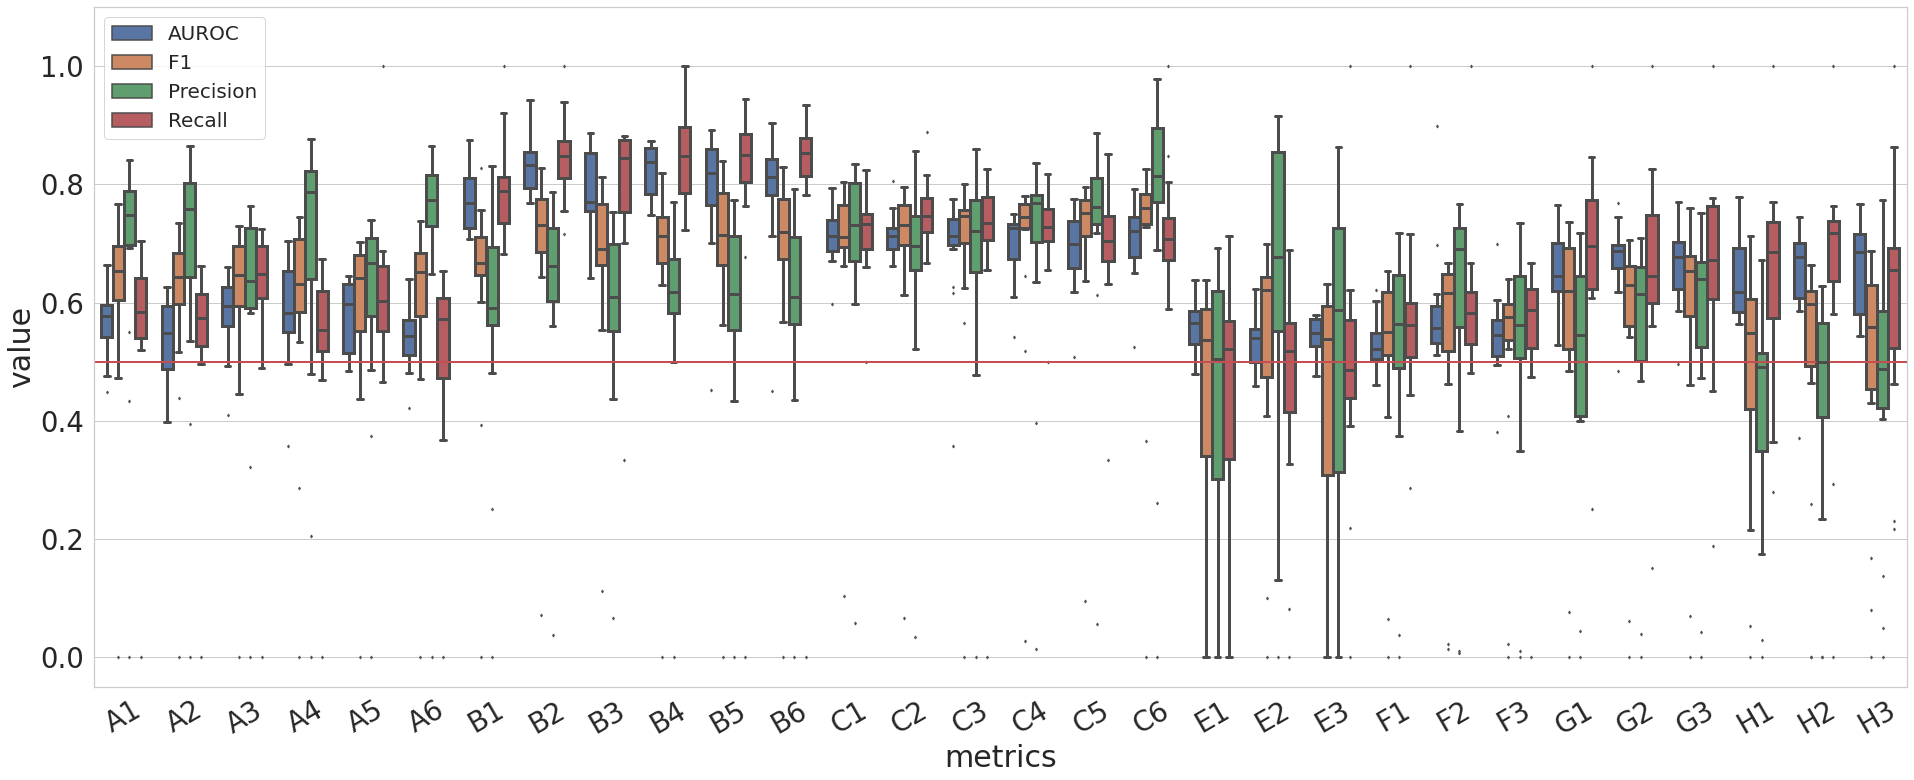

In [28]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import PathPatch
Path="/home/uqomulay/90days/STimage_outputs/Hist2gene/Files/"

a1 = pd.read_csv(Path+'A1_class_score.csv')
a2 = pd.read_csv(Path+'A2_class_score.csv')
a3 = pd.read_csv(Path+'A3_class_score.csv')
a4 = pd.read_csv(Path+'A4_class_score.csv')
a5 = pd.read_csv(Path+'A5_class_score.csv')
a6 = pd.read_csv(Path+'A6_class_score.csv')

b1 = pd.read_csv(Path+'B1_class_score.csv')
b2 = pd.read_csv(Path+'B2_class_score.csv')
b3 = pd.read_csv(Path+'B3_class_score.csv')
b4 = pd.read_csv(Path+'B4_class_score.csv')
b5 = pd.read_csv(Path+'B5_class_score.csv')
b6 = pd.read_csv(Path+'B6_class_score.csv')

c1 = pd.read_csv(Path+'C1_class_score.csv')
c2 = pd.read_csv(Path+'C2_class_score.csv')
c3 = pd.read_csv(Path+'C3_class_score.csv')
c4 = pd.read_csv(Path+'C4_class_score.csv')
c5 = pd.read_csv(Path+'C5_class_score.csv')
c6 = pd.read_csv(Path+'C6_class_score.csv')

e1 = pd.read_csv(Path+'E1_class_score.csv')
e2 = pd.read_csv(Path+'E2_class_score.csv')
e3 = pd.read_csv(Path+'E3_class_score.csv')

f1 = pd.read_csv(Path+'F1_class_score.csv')
f2 = pd.read_csv(Path+'F2_class_score.csv')
f3 = pd.read_csv(Path+'F3_class_score.csv')

g1 = pd.read_csv(Path+'G1_class_score.csv')
g2 = pd.read_csv(Path+'G2_class_score.csv')
g3 = pd.read_csv(Path+'G3_class_score.csv')

h1 = pd.read_csv(Path+'H1_class_score.csv')
h2 = pd.read_csv(Path+'H2_class_score.csv')
h3 = pd.read_csv(Path+'H3_class_score.csv')

roc = pd.concat([a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,e1,e2,e3,f1,f2,f3,g1,g2,g3,h1,h2,h3],axis=0)
roc['metrics'] = roc['metrics'].str.split('_', expand=True)[1]

sns.set(font_scale = 2.5,style="whitegrid")
plt.figure(figsize=(32.5,12.5))
plt.ylim(-0.05, 1.10)
im = sns.boxplot(x="metrics", y="value", hue="variable", data=roc,linewidth=3,width=0.75, flierprops = dict(markerfacecolor = '0.50', markersize = 2))
im.set_xticklabels(im.get_xticklabels(),rotation = 30)
plt.legend(loc="upper left", frameon=True, fontsize=20)
im.axhline(0.5, linewidth=2, color='r')
im.figure.savefig(Path+'Hist2gene_boxplot.png')